In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import math
import time

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
def write_metrics(y_test, y_predict):
    print(' ')
    print('The mean squared error is:',mean_squared_error(y_test, y_predict))
    print('The root mean squared error is:',math.sqrt(mean_squared_error(y_test, y_predict)))
    print('The mean absolute error:',mean_absolute_error(y_test,y_predict))
    print(' ')
    

In [3]:
#get the shot number from the test index
#(potential bug: pass the right df_input that has been used to create y_test. For example: df_input_clean)
def get_shot_num(shot_index,y_test,df_input):
    #print(y_test.iloc[shot_index])
    #print(y_test.iloc[shot_index])
    id_value=y_test.iloc[shot_index].name
    #print(df_time_clean.loc[id_value])
    #print(y_test_reset.loc[shot_index])
    #print(df_input_clean.loc[id_value])
    return(df_input['shot number'].loc[id_value])

In [4]:
#Drop the shots <8000 from the raw max distribution
def clean_shots(df_input,df_time,df_freq_int):
    maxval_freq=df_freq_int.max(axis=1)
    meanval=maxval_freq.mean()
    twosigma=2*maxval_freq.std()
    print('')
    print('Shots with max val below 8000 will be discarded')
    print('')

    #get the indexes of the shots that don't fulfilll the requirement
    #badpoints_up=maxval_freq.index[(maxval_freq>(meanval+twosigma))].tolist()
    badpoints_down=maxval_freq.index[(maxval_freq<8000)].tolist()

    #Drop those shots from the databases
    df_input_clean=df_input.drop(badpoints_down)

    df_time_clean=df_time.drop(badpoints_down)

    df_freq_int_clean=df_freq_int.drop(badpoints_down)

    #reset their indexes
    df_input_clean.reset_index(inplace=True,drop=True) #to start again from 0 (as the other DataFrames)
    df_time_clean.reset_index(inplace=True,drop=True)
    df_freq_int_clean.reset_index(inplace=True,drop=True)

    #TESTING
    #print('Testing!')
    #print(df_freq_int_clean)
    #test the histogram
    #test_maxval_freq=df_freq_int_clean.max(axis=1)
    #test_maxval_freq.hist(bins=50)
    
    return df_input_clean,df_time_clean,df_freq_int_clean

## READ DATASET

In [5]:
df_input=pd.read_hdf('galadriel_dataset.h5','df_input')
df_time=pd.read_hdf('galadriel_dataset.h5','df_time')
df_freq_int=pd.read_hdf('galadriel_dataset.h5','df_freq_int')

#get the arrays and print them
print('Input DF')
print(df_input)

print('----')
print('Time values')
df_time_val=df_time.loc[0]
print(df_time_val)

print('----')
print("Intensity")
df_time= df_time.drop([0]) #drop the time values
df_time.reset_index(drop=True,inplace=True) #to start again from 0 (as the other DataFrames)
print(df_time)

print('----')
print("Freq values")
df_freq_val=df_freq_int.loc[0]
print(df_freq_val)

print('----')
print("Frequency intesity")
df_freq_int= df_freq_int.drop([0]) #drop the freq values
df_freq_int.reset_index(drop=True,inplace=True)
print(df_freq_int)

Input DF
       shot number  order2  order3     order4
0             4731   34900  -17000 -3700000.0
1             4733   34900  -17000 -4600000.0
2             4734   34900  -17000 -4600000.0
3             4735   34900  -17000 -4600000.0
4             4736   34900  -17000 -4500000.0
...            ...     ...     ...        ...
12156        17147   35300   20000 -3800000.0
12157        17148   35300   20000 -3800000.0
12158        17149   35300   20000 -3800000.0
12159        17150   35300   20000 -3700000.0
12160        17151   35300   20000 -3700000.0

[12161 rows x 4 columns]
----
Time values
0    -94.466005
1    -83.969782
2    -73.473559
3    -62.977336
4    -52.481114
5    -41.984891
6    -31.488668
7    -20.992445
8    -10.496223
9      0.000000
10    10.496223
11    20.992445
12    31.488668
13    41.984891
14    52.481114
15    62.977336
16    73.473559
17    83.969782
18    94.466005
Name: 0, dtype: float64
----
Intensity
             0         1         2         3         

In [6]:
#Get the clean shots
df_input_clean,df_time_clean,df_freq_int_clean=clean_shots(df_input,df_time,df_freq_int)


Shots with max val below 8000 will be discarded



In [7]:
df_input_clean.describe()

,shot number,order2,order3,order4
count,12150.000000,12150.000000,12150.000000,1.215000e+04
mean,10969.523374,35096.588477,5574.320988,-4.116642e+06
std,3589.767554,127.187774,13403.691056,2.907178e+05
min,4733.000000,34900.000000,-17000.000000,-4.600000e+06
25%,7865.250000,35000.000000,-6000.000000,-4.400000e+06
50%,10977.500000,35100.000000,5000.000000,-4.100000e+06
75%,14082.750000,35200.000000,17000.000000,-3.900000e+06
max,17151.000000,35300.000000,29000.000000,-3.600000e+06


In [8]:
#save the min and maximums for visualization purposes
min_order2=df_input_clean['order2'].min()
max_order2=df_input_clean['order2'].max()

min_order3=df_input_clean['order3'].min()
max_order3=df_input_clean['order3'].max()

min_order4=df_input_clean['order4'].min()
max_order4=df_input_clean['order4'].max()

### Define input/output

In [9]:
#define input and output for the model
#y=df_input[['order2','order3','order4']]
#X=df_time

y=df_input_clean[['order2','order3','order4']]
X=df_time_clean

In [10]:
#split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

## Linear Regression model

In [11]:
lin_model = LinearRegression()
lin_model.fit(X_train,y_train)

LinearRegression()

In [12]:
lin_model.coef_

array([[ 2.55087777e+03,  2.44415529e+03, -3.45995000e+03,
        -3.07108753e+03, -8.84321627e+02,  1.20626520e+03,
         8.76429381e+02,  8.26130218e+02, -3.31171161e+02,
        -3.74913245e+02,  5.98230583e+00,  4.13412142e+02,
        -6.38111378e+02, -3.59221443e+01, -3.25151156e+02,
         6.15852748e+02, -1.67976887e+03, -1.77045520e+03,
         1.26259878e+02],
       [ 1.56684448e+05,  5.54693729e+04,  1.51588846e+04,
         4.08391714e+04, -2.40873213e+04, -3.93379344e+04,
        -2.84898115e+04, -3.61651251e+04, -3.31615502e+03,
        -1.53592540e+04, -1.08495879e+04,  6.09248770e+04,
        -6.25662823e+04,  6.51765644e+04,  5.17996926e+04,
         4.76844955e+04, -6.69047231e+03,  4.08904184e+04,
         1.16535882e+05],
       [-1.45452048e+07, -1.40909079e+07,  9.69407789e+06,
         2.11211346e+06, -8.42792973e+04, -1.67291464e+06,
         2.27368244e+05,  2.04690460e+05,  2.28817148e+04,
         3.64970924e+05,  2.95570743e+05,  7.06687600e+04,
    

In [13]:
lin_model.score(X_train,y_train)

0.49949985927298984

In [14]:
y_predict_lin=lin_model.predict(X_test)

In [15]:
#Reset the index on y_test to have the same indexes as y_predict
y_test_reset=y_test.reset_index(drop=True)

In [16]:
y_test_reset.head()

,order2,order3,order4
0,34900,-17000,-3900000.0
1,35050,-12000,-4000000.0
2,34900,18000,-3800000.0
3,35250,-7000,-4100000.0
4,35050,7000,-4300000.0


In [17]:
y_predict_lin

array([[   35007.28555315,   -11689.44299384, -3992815.13279365],
       [   35098.23681025,   -10051.80766441, -4083719.43121582],
       [   35087.30477408,    13195.86035935, -4066807.24249192],
       ...,
       [   35083.64295036,    18635.18548912, -4004387.78974515],
       [   35039.05957732,    19353.62069126, -4081631.25759268],
       [   35153.63179004,    21343.88068197, -4039612.78759624]])

In [18]:
'''shot_index=220 #this is not the shot number, nor the original index. It is the index from the model output

ax = plt.subplot(2,2,1) #upper left
ax.scatter(y_test_reset['order2'].loc[shot_index],y_test_reset['order3'].loc[shot_index],label='test')
ax.scatter(y_predict_lin[shot_index][0],y_predict_lin[shot_index][1],label='prediction',marker='s')
#ax.set_xlabel('order 2')
ax.set_ylabel('order 3')
ax.set_xticks([])
plt.xlim(min_order2,max_order2)
plt.ylim(min_order3,max_order3)

ax2= plt.subplot(2,2,3) #lower left
ax2.scatter(y_test_reset['order2'].loc[shot_index],y_test_reset['order4'].loc[shot_index],label='test')
ax2.scatter(y_predict_lin[shot_index][0],y_predict_lin[shot_index][2],label='prediction',marker='s')
ax2.set_xlabel('order 2')
ax2.set_ylabel('order 4')
plt.xlim(min_order2,max_order2)
plt.ylim(min_order4,max_order4)

ax3= plt.subplot(2,2,4) #lower right
ax3.scatter(y_test_reset['order3'].loc[shot_index],y_test_reset['order4'].loc[shot_index],label='test')
ax3.scatter(y_predict_lin[shot_index][1],y_predict_lin[shot_index][2],label='prediction',marker='s')
ax3.set_xlabel('order 3')
ax3.set_yticks([])
plt.xlim(min_order3,max_order3)
plt.ylim(min_order4,max_order4)

plt.legend()'''

"shot_index=220 #this is not the shot number, nor the original index. It is the index from the model output\n\nax = plt.subplot(2,2,1) #upper left\nax.scatter(y_test_reset['order2'].loc[shot_index],y_test_reset['order3'].loc[shot_index],label='test')\nax.scatter(y_predict_lin[shot_index][0],y_predict_lin[shot_index][1],label='prediction',marker='s')\n#ax.set_xlabel('order 2')\nax.set_ylabel('order 3')\nax.set_xticks([])\nplt.xlim(min_order2,max_order2)\nplt.ylim(min_order3,max_order3)\n\nax2= plt.subplot(2,2,3) #lower left\nax2.scatter(y_test_reset['order2'].loc[shot_index],y_test_reset['order4'].loc[shot_index],label='test')\nax2.scatter(y_predict_lin[shot_index][0],y_predict_lin[shot_index][2],label='prediction',marker='s')\nax2.set_xlabel('order 2')\nax2.set_ylabel('order 4')\nplt.xlim(min_order2,max_order2)\nplt.ylim(min_order4,max_order4)\n\nax3= plt.subplot(2,2,4) #lower right\nax3.scatter(y_test_reset['order3'].loc[shot_index],y_test_reset['order4'].loc[shot_index],label='test')

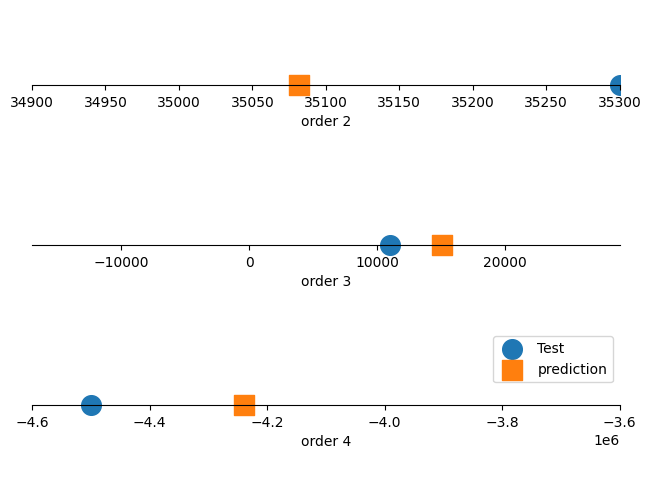

In [19]:
shot_index=220 #this is not the shot number, nor the original index. It is the index from the model output
y_temp=[0]
fig, ax = plt.subplots(3, 1, layout='constrained')
#ax = plt.subplots(3,1) #upper plot
ax[0].scatter(y_test_reset['order2'].loc[shot_index],y_temp,200,label='Test')
ax[0].scatter(y_predict_lin[shot_index][0],y_temp,200,label='prediction',marker='s')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].yaxis.set_visible(False)
ax[0].spines['bottom'].set_position('zero')
ax[0].set_xlabel('order 2')
ax[0].set_xlim(min_order2,max_order2)
#plt.xlim(min_order2,max_order2)
#plt.show()

#ax2 = plt.subplot(3,2) #mid plot
ax[1].scatter(y_test_reset['order3'].loc[shot_index],y_temp,200,label='Test')
ax[1].scatter(y_predict_lin[shot_index][1],y_temp,200,label='prediction',marker='s')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].yaxis.set_visible(False)
ax[1].spines['bottom'].set_position('zero')
ax[1].set_xlabel('order 3')
ax[1].set_xlim(min_order3,max_order3)
#plt.xlim(min_order3,max_order3)
#plt.show()


#ax3 = plt.subplot(3,3) #lower plot
ax[2].scatter(y_test_reset['order4'].loc[shot_index],y_temp,200,label='Test')
ax[2].scatter(y_predict_lin[shot_index][2],y_temp,200,label='prediction',marker='s')
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].spines['left'].set_visible(False)
ax[2].yaxis.set_visible(False)
ax[2].spines['bottom'].set_position('zero')
ax[2].set_xlabel('order 4')
plt.xlim(min_order4,max_order4)
plt.legend()
plt.show()

**Error in the predictions**

In [20]:
#error in the predictions?
print('Error in order2')
write_metrics(y_test['order2'], y_predict_lin[:,0])
print('Error in order3')
write_metrics(y_test['order3'], y_predict_lin[:,1])
print('Error in order4')
write_metrics(y_test['order4'], y_predict_lin[:,2])

#y_test['order2']
#print(y_predict_lin[:][:])
#print(y_predict_lin[:,0])

Error in order2
 
The mean squared error is: 11943.924866441102
The root mean squared error is: 109.28826499876875
The mean absolute error: 90.53547069028774
 
Error in order3
 
The mean squared error is: 29144451.05733575
The root mean squared error is: 5398.560091110939
The mean absolute error: 4321.169173001383
 
Error in order4
 
The mean squared error is: 48970478522.47327
The root mean squared error is: 221292.74394447115
The mean absolute error: 157654.0375928495
 


In [21]:
df_error_lin=abs(y_test_reset-y_predict_lin)

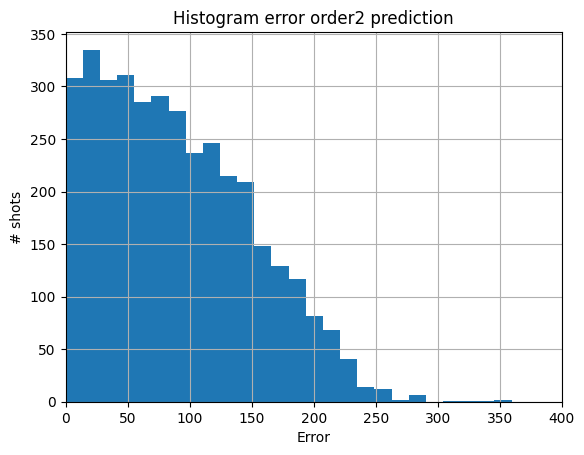

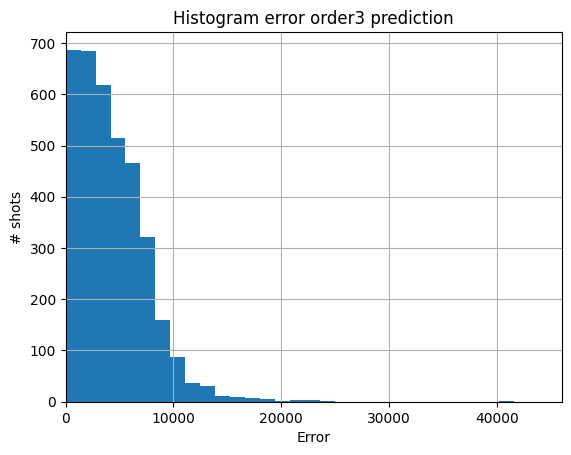

(0.0, 1000000.0)

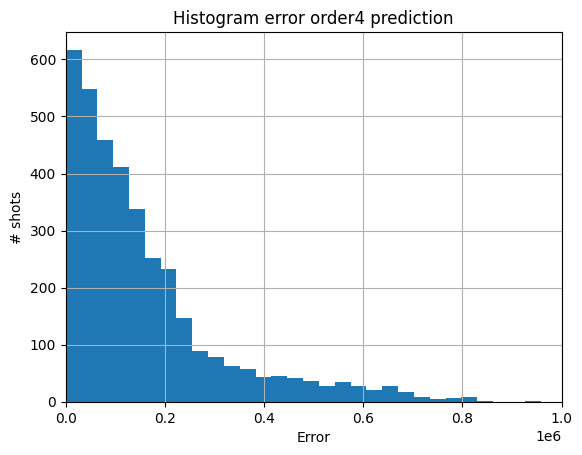

In [22]:
df_error_lin['order2'].hist(bins=30)
plt.xlabel('Error')
plt.ylabel('# shots')
plt.title('Histogram error order2 prediction')
plt.xlim(0,max_order2-min_order2)
plt.show()

df_error_lin['order3'].hist(bins=30)
plt.xlabel('Error')
plt.ylabel('# shots')
plt.title('Histogram error order3 prediction')
plt.xlim(0,max_order3-min_order3)
plt.show()

df_error_lin['order4'].hist(bins=30)
plt.xlabel('Error')
plt.ylabel('# shots')
plt.title('Histogram error order4 prediction')
plt.xlim(0,max_order4-min_order4)

### Random forest regressor

In [23]:
forest_regr = RandomForestRegressor(n_estimators = 300, max_features = 'sqrt',max_depth=20, random_state=18)
forest_regr.fit(X_train,y_train)

RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=300,
                      random_state=18)

In [24]:
y_train

,order2,order3,order4
4094,35000,29000,-4000000.0
213,34900,-10000,-4400000.0
551,34900,1000,-3800000.0
8570,35200,-6000,-4400000.0
6372,35100,13000,-4300000.0
...,...,...,...
599,34900,3000,-4200000.0
5695,35100,-10000,-4400000.0
8006,35150,21000,-3600000.0
1361,34900,29000,-3900000.0


In [25]:
y_predict_forest=forest_regr.predict(X_test)

In [26]:
#Reset the index on y_test to have the same indexes as y_predict
y_test_reset=y_test.reset_index(drop=True)

In [27]:
y_predict_forest

array([[   35002.24429132,   -15361.56046729, -3948263.25039423],
       [   35080.77478208,   -12762.89047623, -3981189.13137476],
       [   34946.76557402,    16370.61346187, -3861917.97982501],
       ...,
       [   34987.03251543,    24146.54881027, -3829391.52330146],
       [   35017.98096129,    21154.49338547, -4013670.1734855 ],
       [   35215.67452438,    18528.36903191, -4092512.39470745]])

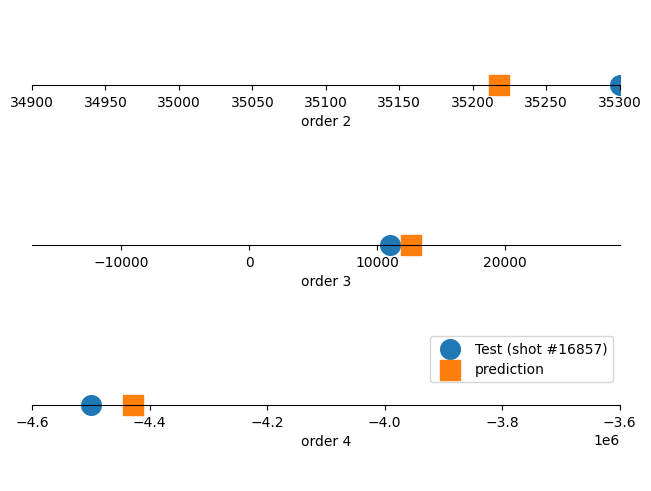

In [28]:
#plot a random prediction

shot_index=220 #this is not the shot number, nor the original index. It is the index from the model output
shot_numb=get_shot_num(shot_index,y_test,df_input_clean)
y_temp=[0]
fig, ax = plt.subplots(3, 1, layout='constrained')
#ax = plt.subplots(3,1) #upper plot
ax[0].scatter(y_test_reset['order2'].loc[shot_index],y_temp,200,label='Test')
ax[0].scatter(y_predict_forest[shot_index][0],y_temp,200,label='prediction',marker='s')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].yaxis.set_visible(False)
ax[0].spines['bottom'].set_position('zero')
ax[0].set_xlabel('order 2')
ax[0].set_xlim(min_order2,max_order2)
#plt.xlim(min_order2,max_order2)
#plt.show()

#ax2 = plt.subplot(3,2) #mid plot
ax[1].scatter(y_test_reset['order3'].loc[shot_index],y_temp,200,label='Test')
ax[1].scatter(y_predict_forest[shot_index][1],y_temp,200,label='prediction',marker='s')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].yaxis.set_visible(False)
ax[1].spines['bottom'].set_position('zero')
ax[1].set_xlabel('order 3')
ax[1].set_xlim(min_order3,max_order3)
#plt.xlim(min_order3,max_order3)
#plt.show()


#ax3 = plt.subplot(3,3) #lower plot
ax[2].scatter(y_test_reset['order4'].loc[shot_index],y_temp,200,label='Test (shot #'+str(shot_numb)+')')
ax[2].scatter(y_predict_forest[shot_index][2],y_temp,200,label='prediction',marker='s')
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].spines['left'].set_visible(False)
ax[2].yaxis.set_visible(False)
ax[2].spines['bottom'].set_position('zero')
ax[2].set_xlabel('order 4')
plt.xlim(min_order4,max_order4)
plt.legend()
plt.show()

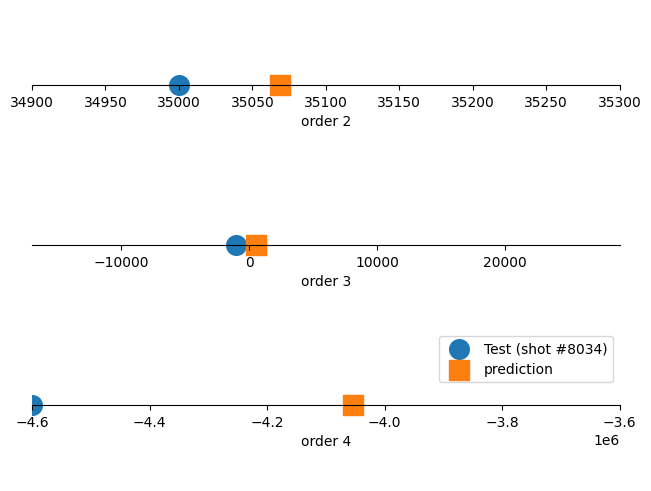

In [29]:
#plot a random prediction
shot_index=100 #this is not the shot number, nor the original index. It is the index from the model output
shot_numb=get_shot_num(shot_index,y_test,df_input_clean)

y_temp=[0]
fig, ax = plt.subplots(3, 1, layout='constrained')
#ax = plt.subplots(3,1) #upper plot
ax[0].scatter(y_test_reset['order2'].loc[shot_index],y_temp,200,label='Test')
ax[0].scatter(y_predict_forest[shot_index][0],y_temp,200,label='prediction',marker='s')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].yaxis.set_visible(False)
ax[0].spines['bottom'].set_position('zero')
ax[0].set_xlabel('order 2')
ax[0].set_xlim(min_order2,max_order2)
#plt.xlim(min_order2,max_order2)
#plt.show()

#ax2 = plt.subplot(3,2) #mid plot
ax[1].scatter(y_test_reset['order3'].loc[shot_index],y_temp,200,label='Test')
ax[1].scatter(y_predict_forest[shot_index][1],y_temp,200,label='prediction',marker='s')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].yaxis.set_visible(False)
ax[1].spines['bottom'].set_position('zero')
ax[1].set_xlabel('order 3')
ax[1].set_xlim(min_order3,max_order3)
#plt.xlim(min_order3,max_order3)
#plt.show()


#ax3 = plt.subplot(3,3) #lower plot
ax[2].scatter(y_test_reset['order4'].loc[shot_index],y_temp,200,label='Test (shot #'+str(shot_numb)+')')
ax[2].scatter(y_predict_forest[shot_index][2],y_temp,200,label='prediction',marker='s')
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].spines['left'].set_visible(False)
ax[2].yaxis.set_visible(False)
ax[2].spines['bottom'].set_position('zero')
ax[2].set_xlabel('order 4')
plt.xlim(min_order4,max_order4)
plt.legend()
plt.show()

In [30]:
#error in the predictions?
print('Error in order2')
write_metrics(y_test['order2'], y_predict_forest[:,0])
print('Error in order3')
write_metrics(y_test['order3'], y_predict_forest[:,1])
print('Error in order4')
write_metrics(y_test['order4'], y_predict_forest[:,2])

Error in order2
 
The mean squared error is: 3462.4043831940694
The root mean squared error is: 58.84219900032688
The mean absolute error: 45.97909042098409
 
Error in order3
 
The mean squared error is: 3730115.687626063
The root mean squared error is: 1931.3507417416606
The mean absolute error: 1254.4870757283238
 
Error in order4
 
The mean squared error is: 34217647291.410675
The root mean squared error is: 184980.12674720134
The mean absolute error: 93915.80585636984
 


In [31]:
df_error_forest=abs(y_test_reset-y_predict_forest)

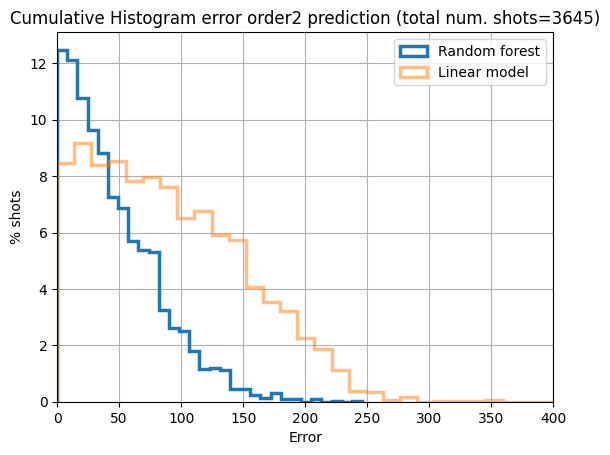

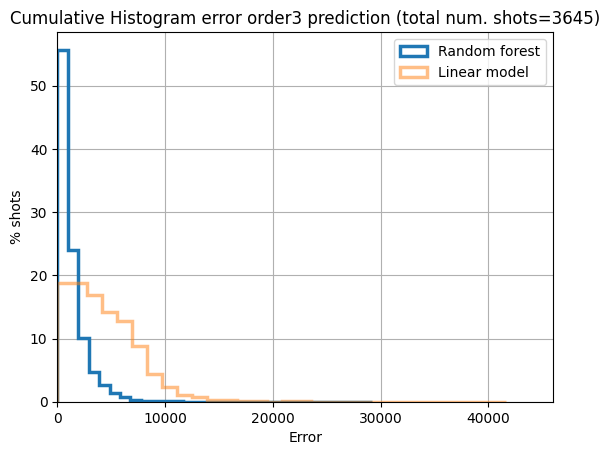

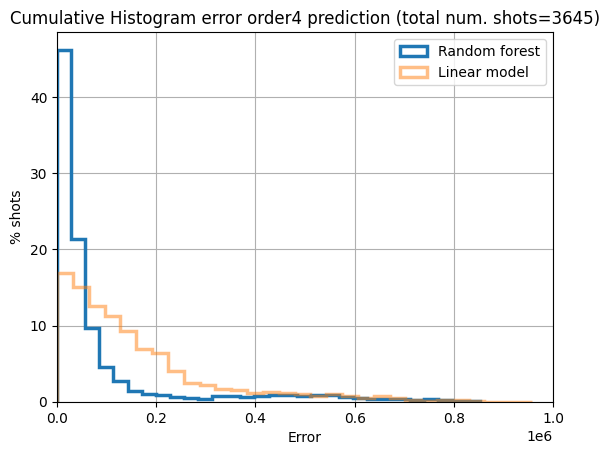

In [32]:
weights_forest_order2 = 100*np.ones_like(df_error_forest['order2']) / len(df_error_forest['order2'])
weights_lin_order2 = 100*np.ones_like(df_error_lin['order2']) / len(df_error_lin['order2'])
df_error_forest['order2'].hist(bins=30,label='Random forest',weights=weights_forest_order2,histtype="step",linewidth=2.5)
df_error_lin['order2'].hist(bins=30,alpha=0.5,label='Linear model',weights=weights_lin_order2,histtype="step",linewidth=2.5)
plt.xlabel('Error')
plt.ylabel('% shots')
plt.title('Cumulative Histogram error order2 prediction (total num. shots='+str(len(df_error_forest))+')')
plt.xlim(0,max_order2-min_order2)
plt.legend()
plt.show()

weights_forest_order3 = 100*np.ones_like(df_error_forest['order3']) / len(df_error_forest['order3'])
weights_lin_order3 = 100*np.ones_like(df_error_lin['order3']) / len(df_error_lin['order3'])
df_error_forest['order3'].hist(bins=30,label='Random forest',weights=weights_forest_order3,histtype="step",linewidth=2.5)
df_error_lin['order3'].hist(bins=30,alpha=0.5,label='Linear model',weights=weights_lin_order3,histtype="step",linewidth=2.5)
plt.xlabel('Error')
plt.ylabel('% shots')
plt.title('Cumulative Histogram error order3 prediction (total num. shots='+str(len(df_error_forest))+')')
plt.xlim(0,max_order3-min_order3)
plt.legend()
plt.show()

weights_forest_order4 = 100*np.ones_like(df_error_forest['order4']) / len(df_error_forest['order4'])
weights_lin_order4 = 100*np.ones_like(df_error_lin['order4']) / len(df_error_lin['order4'])
df_error_forest['order4'].hist(bins=30,label='Random forest',weights=weights_forest_order4,histtype="step",linewidth=2.5)
df_error_lin['order4'].hist(bins=30,alpha=0.5,label='Linear model',weights=weights_lin_order4,histtype="step",linewidth=2.5)
plt.xlabel('Error')
plt.ylabel('% shots')
plt.title('Cumulative Histogram error order4 prediction (total num. shots='+str(len(df_error_forest))+')')
plt.xlim(0,max_order4-min_order4)
plt.legend()

### Model performance (random forest)

### TEST SHOTS (APR 12)

In [33]:
X_test_shot0=[[0.001199,0.00104,0.004285,0.005213,0.026507,0.101424,0.261314,0.482225,0.783666,1.0,0.82783,0.244637,0.016048,0.241497,0.34343,0.031268,0.142042,0.087892,0.057908]]
y_predict_shot0=forest_regr.predict(X_test_shot0)
print(y_predict_shot0)

[[   35184.86035354    23564.02777778 -4409000.        ]]


In [34]:
X_test_shot1=[[0,0.2,0.2,0.2,0.2,0,0,0.3,0.8,1,0.8,0.3,0,0,0,0,0,0,0]]
y_predict_shot1=forest_regr.predict(X_test_shot1)
print(y_predict_shot1)

[[ 3.50750000e+04 -4.63333333e+02 -4.26466667e+06]]


In [35]:
X_test_shot2=[[0,0,0,0,0.5,0,0,0.3,0.8,1,0.8,0.3,0,0,0,0,0,0,0]]
y_predict_shot2=forest_regr.predict(X_test_shot2)
print(y_predict_shot2)

[[   35073.33333333     7236.66666667 -4270666.66666667]]


In [36]:
X_test_shot3=[[0,0.5,0,0,0,0,0,0.3,0.8,1,0.8,0.3,0,0,0,0,0,0,0]]
y_predict_shot3=forest_regr.predict(X_test_shot3)
print(y_predict_shot3)

[[   35108.83333333     7466.66666667 -4280000.        ]]


## NEURAL NETWORK

In [37]:
# set the device we will be using to train the model
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device="cpu"
print("We are using:",device)

We are using: cpu


In [38]:
#regularize target
y_train_reg = y_train.copy()
y_test_reg=y_test.copy()

y_train_reg['order2']= y_train_reg['order2']-y_train['order2'].mean()
y_train_reg['order2']= y_train_reg['order2']/y_train['order2'].std()

y_train_reg['order3']= y_train_reg['order3']-y_train['order3'].mean()
y_train_reg['order3']= y_train_reg['order3']/y_train['order3'].std()

y_train_reg['order4']= y_train_reg['order4']-y_train['order4'].mean()
y_train_reg['order4']= y_train_reg['order4']/y_train['order4'].std()

#Regularize the test dataset with the SAME values as the training set
y_test_reg['order2']= y_test_reg['order2']-y_train['order2'].mean()
y_test_reg['order2']= y_test_reg['order2']/y_train['order2'].std()

y_test_reg['order3']= y_test_reg['order3']-y_train['order3'].mean()
y_test_reg['order3']= y_test_reg['order3']/y_train['order3'].std()

y_test_reg['order4']= y_test_reg['order4']-y_train['order4'].mean()
y_test_reg['order4']= y_test_reg['order4']/y_train['order4'].std()

#print(y_train['order2'].mean())
#print(y_test_reg['order2'])
print(y_test_reg['order4'])

23       0.746839
4273     0.403606
1046     1.090071
9925     0.060373
4816    -0.626092
           ...   
6828     1.433304
4559    -0.282859
4014     1.090071
3894     0.403606
10701    0.060373
Name: order4, Length: 3645, dtype: float64


In [39]:
#convert to tensor (use regularized values)
X_train_tensor=torch.tensor(X_train.values,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train_reg.values,dtype=torch.float32)

X_test_tensor=torch.tensor(X_test.values,dtype=torch.float32)
y_test_tensor=torch.tensor(y_test_reg.values,dtype=torch.float32)

In [40]:
#define the neural network
class perceptron_medium(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1=nn.Linear(19,19)
        self.act1= nn.ReLU()
        self.hidden2=nn.Linear(19,15)
        self.act2=nn.ReLU()
        self.hidden3=nn.Linear(15,10)
        self.act3=nn.ReLU()
        self.hidden4=nn.Linear(10,5)
        self.act4=nn.ReLU()
        self.output=nn.Linear(5,3)

    def forward(self,x):
        x=self.act1(self.hidden1(x))
        x=self.act2(self.hidden2(x))
        x=self.act3(self.hidden3(x))
        x=self.act4(self.hidden4(x))
        x=self.output(x)
        return x

In [41]:
#define the neural network
class cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=1)
        self.act1= nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=3,stride=2)

        self.flat = nn.Flatten()

        self.fc2 = nn.Linear(9, 9)
        self.act2= nn.ReLU()

        self.output=nn.Linear(9,3)

    def forward(self,x):
        x=self.act1(self.conv1(x))
        x=self.pool1(x)
        x=self.flat(x)
        x=self.act2(self.fc2(x))
        x=self.output(x)
        return x

In [42]:
#define the neural network
class perceptron(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1=nn.Linear(19,30)
        self.act1= nn.ReLU()
        self.hidden2=nn.Linear(30,30)
        self.act2=nn.ReLU()
        self.hidden3=nn.Linear(30,30)
        self.act3=nn.ReLU()
        self.hidden4=nn.Linear(30,25)
        self.act4=nn.ReLU()
        self.hidden5=nn.Linear(25,15)
        self.act5=nn.ReLU()
        self.hidden6=nn.Linear(15,10)
        self.act6=nn.ReLU()
        self.output=nn.Linear(10,3)

    def forward(self,x):
        x=self.act1(self.hidden1(x))
        x=self.act2(self.hidden2(x))
        x=self.act3(self.hidden3(x))
        x=self.act4(self.hidden4(x))
        x=self.act5(self.hidden5(x))
        x=self.act6(self.hidden6(x))
        x=self.output(x)
        return x

In [43]:
#hyperparameters
n_epochs=200
batch_size=20
print_freq=10
learning_rate=0.001

In [44]:
startTime = time.time()
#Create the model and define the loss and optimizer
nn_model=perceptron().to(device)
#nn_model=cnn().to(device)
#print(nn_model)

loss_func=nn.MSELoss() #mean squared error
optimizer = optim.Adam(nn_model.parameters(), lr=learning_rate)

#main training loop
train_error=[]
test_error=[]
epoch_list=[]
for epoch in range(n_epochs):
    # set the model in training mode
    nn_model.train()

    train_loss=0
    for i in range(0,len(X_train_tensor),batch_size):
        X_batch=X_train_tensor[i:i+batch_size]
        ##X_batch=X_batch.unsqueeze(1)
        ##y_batch=y_batch.unsqueeze(1)
        y_batch=y_train_tensor[i:i+batch_size]
        X_batch, y_batch =(X_batch.to(device), y_batch.to(device))
        y_predict_nn=nn_model(X_batch)
        loss=loss_func(y_predict_nn,y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss

    #get training error
    train_loss=train_loss/(len(X_train_tensor)/batch_size)
    train_error.append(train_loss.detach().cpu().numpy())
    #evaluate test error
    with torch.no_grad():
        nn_model.eval()
        X_test_model=X_test_tensor#.unsqueeze(1)
        y_test_model=y_test_tensor#.unsqueeze(1)
        (X_test_model, y_test_model) = (X_test_model.to(device), y_test_model.to(device))
        y_predict_test=nn_model(X_test_model)
        test_loss=loss_func(y_predict_test,y_test_tensor)
        test_error.append(test_loss.detach().cpu().numpy())

    epoch_list.append(epoch+1)
    
    if(epoch%print_freq==0 or epoch+1==n_epochs):
        print(f'Finished epoch {epoch},latest loss {train_loss}')
#print(train_error)
#print(test_error)
endTime = time.time()
print("Total time taken to train the model: {:.2f}s".format(endTime - startTime))

Finished epoch 0,latest loss 0.850347101688385
Finished epoch 10,latest loss 0.48089897632598877
Finished epoch 20,latest loss 0.43620404601097107
Finished epoch 30,latest loss 0.3400900065898895
Finished epoch 40,latest loss 0.3009699285030365
Finished epoch 50,latest loss 0.2817550301551819
Finished epoch 60,latest loss 0.2709130048751831
Finished epoch 70,latest loss 0.2617019712924957
Finished epoch 80,latest loss 0.25403541326522827
Finished epoch 90,latest loss 0.24696554243564606
Finished epoch 100,latest loss 0.24156445264816284
Finished epoch 110,latest loss 0.2370808869600296
Finished epoch 120,latest loss 0.23251044750213623
Finished epoch 130,latest loss 0.2273368388414383
Finished epoch 140,latest loss 0.22298599779605865
Finished epoch 150,latest loss 0.2173393964767456
Finished epoch 160,latest loss 0.21284477412700653
Finished epoch 170,latest loss 0.20772628486156464
Finished epoch 180,latest loss 0.20365223288536072
Finished epoch 190,latest loss 0.1996351033449173
Fi

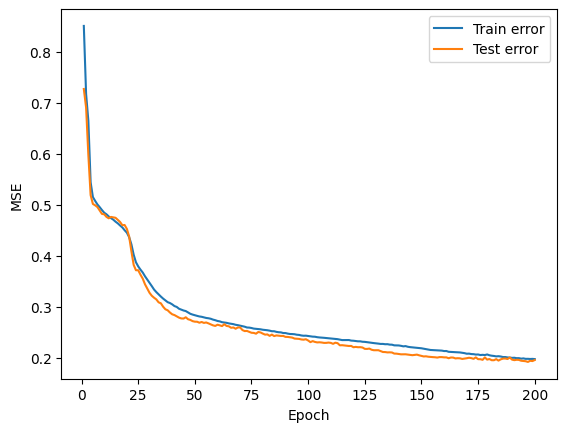

In [45]:
plt.plot(epoch_list,train_error,label='Train error')
plt.plot(epoch_list,test_error,label='Test error')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()

In [46]:
#Make the prediction (output is normalized)
y_predict_nn_tensor=nn_model(X_test_model)
y_predict_nn_reg=y_predict_nn_tensor.detach().cpu().numpy()

In [47]:
#Revert the target regularization
y_predict_nn=y_predict_nn_reg.copy()
y_predict_nn[:,0]=(y_predict_nn_reg[:,0]*y_train['order2'].std())+y_train['order2'].mean()
y_predict_nn[:,1]=(y_predict_nn_reg[:,1]*y_train['order3'].std())+y_train['order3'].mean()
y_predict_nn[:,2]=(y_predict_nn_reg[:,2]*y_train['order4'].std())+y_train['order4'].mean()


In [48]:
#Reset the index on y_test to have the same indexes as y_predict
y_test_reset=y_test.reset_index(drop=True)

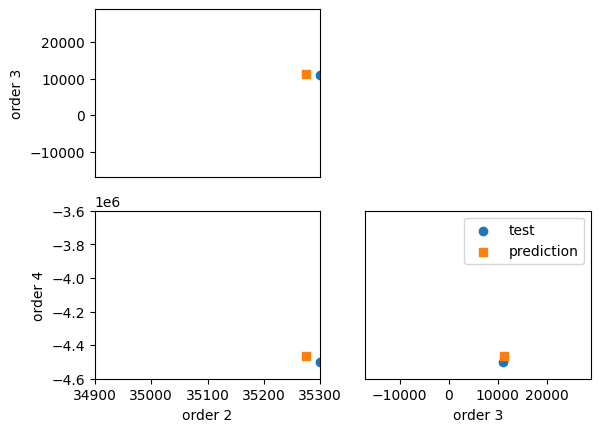

In [49]:
shot_index=220 #this is not the shot number, nor the original index. It is the index from the model output

ax = plt.subplot(2,2,1) #upper left
ax.scatter(y_test_reset['order2'].loc[shot_index],y_test_reset['order3'].loc[shot_index],label='test')
ax.scatter(y_predict_nn[shot_index][0],y_predict_nn[shot_index][1],label='prediction',marker='s')
#ax.set_xlabel('order 2')
ax.set_ylabel('order 3')
ax.set_xticks([])
plt.xlim(min_order2,max_order2)
plt.ylim(min_order3,max_order3)

ax2= plt.subplot(2,2,3) #lower left
ax2.scatter(y_test_reset['order2'].loc[shot_index],y_test_reset['order4'].loc[shot_index],label='test')
ax2.scatter(y_predict_nn[shot_index][0],y_predict_nn[shot_index][2],label='prediction',marker='s')
ax2.set_xlabel('order 2')
ax2.set_ylabel('order 4')
plt.xlim(min_order2,max_order2)
plt.ylim(min_order4,max_order4)

ax3= plt.subplot(2,2,4) #lower right
ax3.scatter(y_test_reset['order3'].loc[shot_index],y_test_reset['order4'].loc[shot_index],label='test')
ax3.scatter(y_predict_nn[shot_index][1],y_predict_nn[shot_index][2],label='prediction',marker='s')
ax3.set_xlabel('order 3')
ax3.set_yticks([])
plt.xlim(min_order3,max_order3)
plt.ylim(min_order4,max_order4)

plt.legend()

In [50]:
#error in the predictions?
print('Error in order2')
write_metrics(y_test['order2'], y_predict_nn[:,0])
print('Error in order3')
write_metrics(y_test['order3'], y_predict_nn[:,1])
print('Error in order4')
write_metrics(y_test['order4'], y_predict_nn[:,2])

Error in order2
 
The mean squared error is: 2355.708132821542
The root mean squared error is: 48.535637760531614
The mean absolute error: 37.646429183813446
 
Error in order3
 
The mean squared error is: 4372087.281778591
The root mean squared error is: 2090.9536775783895
The mean absolute error: 1461.0866820451818
 
Error in order4
 
The mean squared error is: 35286459587.06994
The root mean squared error is: 187846.90465128762
The mean absolute error: 109467.4170781893
 


In [51]:
df_error_nn=abs(y_test_reset-y_predict_nn)

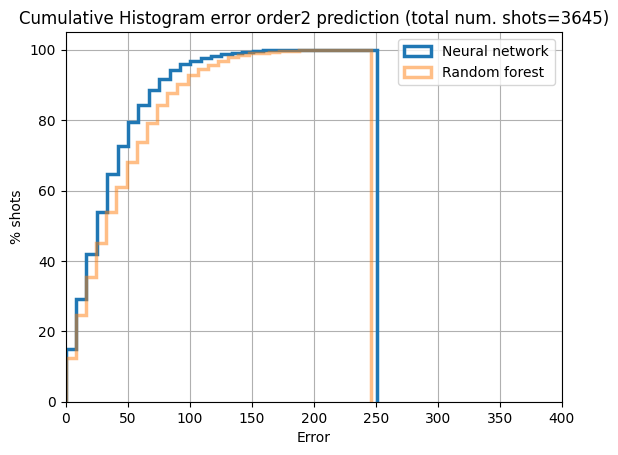

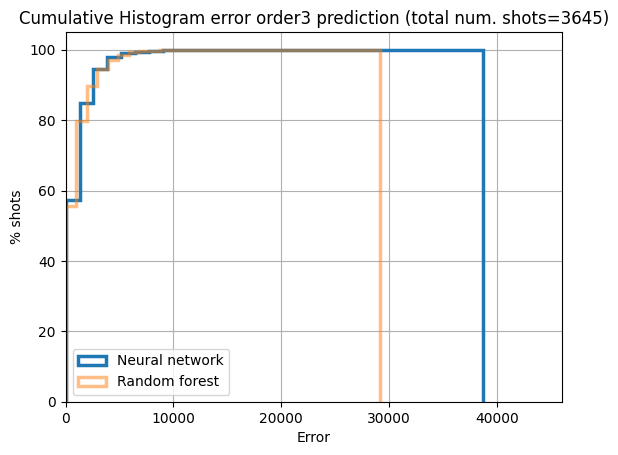

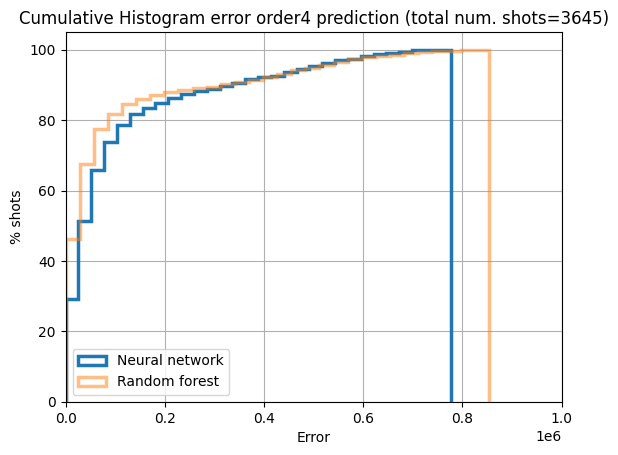

In [52]:
weights_forest_order2 = 100*np.ones_like(df_error_forest['order2']) / len(df_error_forest['order2'])
weights_nn_order2 = 100*np.ones_like(df_error_nn['order2']) / len(df_error_nn['order2'])
df_error_nn['order2'].hist(bins=30,label='Neural network',cumulative=True,weights=weights_nn_order2,histtype="step",linewidth=2.5)
df_error_forest['order2'].hist(bins=30,alpha=0.5,label='Random forest',cumulative=True,weights=weights_forest_order2,histtype="step",linewidth=2.5)
plt.xlabel('Error')
plt.ylabel('% shots')
plt.title('Cumulative Histogram error order2 prediction (total num. shots='+str(len(df_error_forest))+')')
plt.xlim(0,max_order2-min_order2)
plt.legend()
plt.show()

weights_forest_order3 = 100*np.ones_like(df_error_forest['order3']) / len(df_error_forest['order3'])
weights_nn_order3 = 100*np.ones_like(df_error_nn['order3']) / len(df_error_nn['order3'])
df_error_nn['order3'].hist(bins=30,label='Neural network',cumulative=True,weights=weights_nn_order3,histtype="step",linewidth=2.5)
df_error_forest['order3'].hist(bins=30,alpha=0.5,label='Random forest',cumulative=True,weights=weights_forest_order3,histtype="step",linewidth=2.5)
plt.xlabel('Error')
plt.ylabel('% shots')
plt.title('Cumulative Histogram error order3 prediction (total num. shots='+str(len(df_error_nn))+')')
plt.xlim(0,max_order3-min_order3)
plt.legend()
plt.show()

weights_forest_order4 = 100*np.ones_like(df_error_forest['order4']) / len(df_error_forest['order4'])
weights_nn_order4 = 100*np.ones_like(df_error_nn['order4']) / len(df_error_nn['order4'])
df_error_nn['order4'].hist(bins=30,label='Neural network',cumulative=True,weights=weights_nn_order4,histtype="step",linewidth=2.5)
df_error_forest['order4'].hist(bins=30,alpha=0.5,label='Random forest',cumulative=True,weights=weights_forest_order4,histtype="step",linewidth=2.5)
plt.xlabel('Error')
plt.ylabel('% shots')
plt.title('Cumulative Histogram error order4 prediction (total num. shots='+str(len(df_error_nn))+')')
plt.xlim(0,max_order4-min_order4)
plt.legend()

In [53]:
#test convolutions
X_test_conv=X_train_tensor[0:5]
X_test_conv=X_test_conv.unsqueeze(1)
print(X_test_conv)

tensor([[[1.3620e-03, 2.6790e-03, 3.0540e-03, 1.1577e-02, 3.6666e-02,
          7.4011e-02, 1.7498e-01, 3.7534e-01, 7.0823e-01, 1.0000e+00,
          7.8048e-01, 2.1310e-01, 4.0589e-02, 1.5884e-01, 2.5978e-01,
          5.4142e-02, 5.7463e-02, 4.7770e-02, 1.9636e-02]],

        [[4.2300e-03, 9.7100e-04, 1.4540e-02, 1.0210e-02, 1.3061e-01,
          1.5348e-01, 5.5830e-03, 3.8370e-01, 1.0000e+00, 9.5435e-01,
          3.8695e-01, 7.6272e-02, 1.5083e-02, 5.7180e-03, 4.1690e-03,
          1.8200e-03, 1.1780e-03, 5.4030e-03, 4.1160e-03]],

        [[3.7310e-03, 8.8500e-04, 2.1265e-02, 7.2996e-02, 6.3527e-02,
          5.7467e-02, 1.8567e-01, 3.2997e-01, 6.6429e-01, 1.0000e+00,
          7.5069e-01, 2.2719e-01, 6.0057e-02, 8.0767e-02, 2.5093e-02,
          3.0468e-02, 2.8956e-02, 7.8440e-03, 5.4960e-03]],

        [[2.4800e-03, 2.8200e-04, 8.1160e-03, 2.5993e-02, 5.3943e-02,
          6.8064e-02, 6.2013e-02, 4.3868e-01, 1.0000e+00, 8.4577e-01,
          2.6848e-01, 2.7702e-02, 3.0820e-03, 1

In [54]:
#In the conv function, the shape of tensor should be[batch_size,channels,len]
print(X_test_conv.shape)

torch.Size([5, 1, 19])


In [55]:
cnn1d_1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=1,bias=False)
print(cnn1d_1.weight)
print(cnn1d_1(X_test_conv))

Parameter containing:
tensor([[[ 0.3444, -0.3807,  0.2324]]], requires_grad=True)
tensor([[[ 1.0412e-04,  1.5906e-04,  2.4506e-03,  5.1658e-03,  7.2298e-03,
           2.5119e-02,  4.6111e-02,  8.1978e-02,  9.2076e-02,  4.4656e-02,
           9.6859e-02,  1.9713e-01,  9.4858e-02,  1.3889e-02, -3.1597e-02,
           8.2220e-02,  7.8758e-03,  6.1712e-03,  8.9788e-03]],

        [[-1.3845e-03,  4.4662e-03, -2.8276e-03,  3.1473e-02, -1.0532e-02,
          -1.2141e-02,  1.3990e-01,  8.8256e-02, -2.6716e-02,  7.1072e-02,
           1.9914e-01,  1.0775e-01,  2.1858e-02,  3.9873e-03,  8.0544e-04,
           1.0169e-03,  1.4340e-03, -6.9442e-04,  2.9417e-04]],

        [[-1.2146e-03,  5.8899e-03,  9.1737e-03, -5.6989e-03,  1.4315e-02,
           4.3154e-02,  2.5797e-02,  9.2721e-02,  9.3175e-02,  2.2600e-02,
           1.1147e-01,  1.8604e-01,  7.4159e-02, -4.2276e-03,  2.5347e-02,
           3.7740e-03,  1.2947e-03,  8.2646e-03,  6.0962e-04]],

        [[-8.7848e-04,  2.6329e-03,  3.0482e-03,

In [56]:
#FC layer
fc_test=nn.Linear(19,4)
print(fc_test.weight)
print(fc_test(X_test_conv))

Parameter containing:
tensor([[ 0.0781,  0.1501,  0.0026, -0.1074, -0.1004,  0.2112,  0.0645, -0.1027,
         -0.1290, -0.1732, -0.0824, -0.1990,  0.2253,  0.0661,  0.1720, -0.0991,
          0.1403,  0.2262, -0.2015],
        [-0.1304,  0.1006,  0.1166, -0.0833, -0.2283, -0.2129,  0.0548, -0.0606,
          0.1931,  0.0535, -0.1707, -0.1004,  0.0746,  0.1835, -0.0999, -0.0009,
         -0.2065, -0.1425, -0.0928],
        [-0.1667, -0.2124,  0.1770,  0.2204, -0.1228,  0.1041, -0.0008,  0.1607,
         -0.0784,  0.1717, -0.0309, -0.0218, -0.0593,  0.0924, -0.0065, -0.1749,
          0.1436,  0.0890,  0.1055],
        [-0.0712,  0.0066, -0.0671,  0.1373,  0.1340, -0.1280,  0.1067, -0.2045,
          0.0532,  0.0148, -0.0891,  0.0182, -0.0324,  0.1941, -0.0920,  0.1604,
         -0.0925,  0.1548,  0.0255]], requires_grad=True)
tensor([[[-0.3420, -0.1930,  0.1631, -0.1966]],

        [[-0.3854, -0.0907,  0.1320, -0.1832]],

        [[-0.3931, -0.1771,  0.1597, -0.1747]],

        [[-0.3

In [57]:
print(cnn1d_1(X_test_conv))

tensor([[[ 1.0412e-04,  1.5906e-04,  2.4506e-03,  5.1658e-03,  7.2298e-03,
           2.5119e-02,  4.6111e-02,  8.1978e-02,  9.2076e-02,  4.4656e-02,
           9.6859e-02,  1.9713e-01,  9.4858e-02,  1.3889e-02, -3.1597e-02,
           8.2220e-02,  7.8758e-03,  6.1712e-03,  8.9788e-03]],

        [[-1.3845e-03,  4.4662e-03, -2.8276e-03,  3.1473e-02, -1.0532e-02,
          -1.2141e-02,  1.3990e-01,  8.8256e-02, -2.6716e-02,  7.1072e-02,
           1.9914e-01,  1.0775e-01,  2.1858e-02,  3.9873e-03,  8.0544e-04,
           1.0169e-03,  1.4340e-03, -6.9442e-04,  2.9417e-04]],

        [[-1.2146e-03,  5.8899e-03,  9.1737e-03, -5.6989e-03,  1.4315e-02,
           4.3154e-02,  2.5797e-02,  9.2721e-02,  9.3175e-02,  2.2600e-02,
           1.1147e-01,  1.8604e-01,  7.4159e-02, -4.2276e-03,  2.5347e-02,
           3.7740e-03,  1.2947e-03,  8.2646e-03,  6.0962e-04]],

        [[-8.7848e-04,  2.6329e-03,  3.0482e-03,  5.4368e-03,  4.2365e-03,
           7.0818e-03,  1.0178e-01,  8.6762e-02, -3.301